In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pickle
import math
from tqdm import tqdm

%matplotlib inline

base_dir = 'YOUR_PATH_HERE'
h5ad_path = "H5AD_PROCESSED_PATH_HERE"


save_dir = base_dir + "figs/"
analysis_dir = base_dir + "umi_analysis/"


In [ ]:
# Your model function
def naive_pred_f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

######## forward model for computing expected number of collided UMIs given true n_umis, and an empirical distribution of UMI probabilities
def compute_non_unif_estimator(umi_prob_arr, n_umis_true,K):
    """
    Compute the estimator for non-collided UMI counts.
    
    Parameters:
    umi_prob_arr (numpy.ndarray): Array of UMI probabilities.
    n_umis_true (int): True number of UMIs.
    K (int): Total number of UMIs.
    """
    
    assert len(umi_prob_arr) == K, "Length of umi_prob_arr must be equal to K"
    # assert n_umis_true <= K, "n_umis_true must be less than or equal to K"
    
    # Compute the expected number of UMIs from collisions
    
    return K - np.sum( (1-umi_prob_arr)**n_umis_true )
    
    
def compute_naive_unif_estimator(n_umis_true, K):
    """
    Compute the naive estimator for non-collided UMI counts.
    """
    return K * (1 - (1 - 1 / K)**n_umis_true)

def construct_synthetic_umi_arr_perbp(prob_arr, length=5):
    """
    Constructs a synthetic UMI probability array based on the provided length 4 probability array (A C G T)
    
    Parameters:
    prob_arr (numpy.ndarray): The probability array for length 4 UMIs (A, C, G, T).
    length (int): The length of the UMI.
    
    Returns:
    numpy.ndarray: The synthetic UMI probability array.
    """

    synthetic_umi_prob_arr =[]
    ######## for all the poynomial types
    for num_as in range(length + 1):
        for num_cs in range(length - num_as + 1):
            for num_gs in range(length - num_as - num_cs + 1):
                num_ts = length - num_as - num_cs - num_gs
                if num_ts < 0:
                    continue
                # Calculate the probability for this combination
                prob = (prob_arr[0] ** num_as) * (prob_arr[1] ** num_cs) * (prob_arr[2] ** num_gs) * (prob_arr[3] ** num_ts)
                
                coeff = math.factorial(length) / (math.factorial(num_as) * math.factorial(num_cs) * math.factorial(num_gs) * math.factorial(num_ts))
                coeff = int(coeff)  # Ensure coeff is an integer
                # Append the probability multiplied by the number of combinations
                synthetic_umi_prob_arr.extend([prob] * coeff)
    return np.array(synthetic_umi_prob_arr) * 1.0 / np.sum(synthetic_umi_prob_arr)  # Normalize to sum to 1


In [ ]:
#### read the dictionaries from the file

fpath=analysis_dir+'/ensembl2symbol.pkl'

with open(fpath, 'rb') as f:
    map_e2s = pickle.load(f)
    map_s2e = pickle.load(f)
    
    
directory = h5ad_path+"/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/"  # Directory for 1k_PBMCs


adata_dict = {}
# ivals = range(1, 13)
ivals = [4,5,12]
for i in ivals:
    adata_dict[i] = sc.read_h5ad(directory + f"adata_{i}.h5ad")

In [7]:
min_ct_threshold = 10


bc_order = adata_dict[12].obs_names.tolist()

# Reindex the matrix to ensure rows/columns are in sorted order of bc_order and gene_order
adata_12_vals = adata_dict[12][bc_order].X.flatten()
adata_5_vals = adata_dict[5][bc_order].X.flatten()

# Mask based only on adata_12_vals
mask = (adata_12_vals >= min_ct_threshold)
len_12_cts_reduced = adata_12_vals[mask]
len_5_cts_reduced = adata_5_vals[mask]

In [ ]:
######### make all_genes_per_bp_freqs_df
cleaned_tsv = pd.read_csv(analysis_dir+'/cleaned_umis_1k.tsv', sep='\t')

per_gene_umi_counts = cleaned_tsv.groupby(['GX', 'UB']).size().reset_index(name='count')

def calculate_basepair_frequencies(df):
    # Get sequence length (assuming all sequences are same length)
    seq_length = len(df['UB'].iloc[0])
    nucleotides = ['A', 'C', 'G', 'T']
    
    # Initialize result dataframe
    result = pd.DataFrame(0, index=range(seq_length), columns=nucleotides)
    
    # For each position in the sequence
    for pos in range(seq_length):
        # Extract nucleotide at this position for all sequences
        nucleotides_at_pos = df['UB'].str[pos]
        
        # For each nucleotide type, sum the counts
        for nuc in nucleotides:
            mask = nucleotides_at_pos == nuc
            total_count = df.loc[mask, 'count'].sum()
            result.loc[pos, nuc] = total_count
    
    return result


######### for all genes, compute the average umi basepair frequencies, put in a dataframe
synth_len = 5
per_gene_umi_counts_synth = per_gene_umi_counts.copy()
per_gene_umi_counts_synth['UB'] = per_gene_umi_counts_synth['UB'].str[:synth_len]
per_gene_umi_counts_synth = per_gene_umi_counts_synth.groupby(['GX', 'UB']).sum().reset_index()
print('starting')
all_genes_per_bp_freqs = []
for gx, red_df in tqdm(per_gene_umi_counts_synth.groupby('GX')):
    if red_df.empty:
        print(f'No data for gene {gx}, skipping...')
        continue
    gene_freqs_per_bp = calculate_basepair_frequencies(red_df)
    overall_freqs = gene_freqs_per_bp.sum(axis=0)
    overall_freqs.name = gx  # Set the name for the series
    all_genes_per_bp_freqs.append(overall_freqs)

    
    
#### # Create a DataFrame from the list of Series
all_genes_per_bp_freqs_df = pd.DataFrame(all_genes_per_bp_freqs)

all_genes_per_bp_freqs_df.index.name = 'GX'
######## add column for total counts / synth_len (num UMIs), then normalize so that the remaining columns sum to 1
total_cts = all_genes_per_bp_freqs_df.sum(axis=1)
all_genes_per_bp_freqs_df = all_genes_per_bp_freqs_df.div(total_cts, axis=0)  # Normalize each row by its total count
all_genes_per_bp_freqs_df['TV_distance_from_uniform'] = all_genes_per_bp_freqs_df[['A', 'C', 'G', 'T']].sub(0.25).abs().sum(axis=1) / 2

###### add column for TV distance from uniform
all_genes_per_bp_freqs_df['total_counts'] = total_cts/5
all_genes_per_bp_freqs_df = all_genes_per_bp_freqs_df.reset_index()

all_genes_per_bp_freqs_df.sort_values(by='total_counts', ascending=False, inplace=True)
    
all_genes_per_bp_freqs_df.to_csv(analysis_dir+'/GX_umi_5_freqs.tsv', sep='\t', index=False)

True TV distance = 0.067


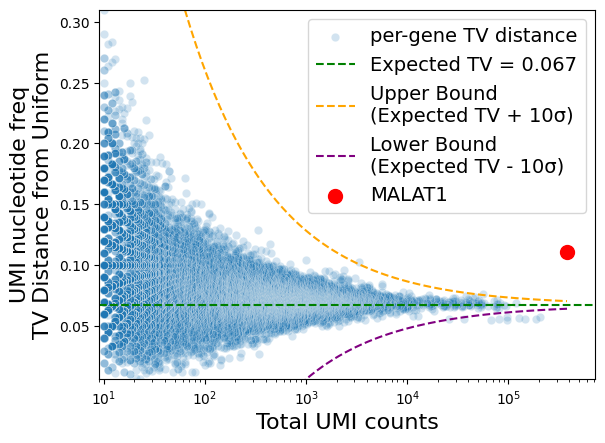

In [ ]:
############# Figure generation for paper: fig:malat_detection


all_genes_per_bp_freqs_df = pd.read_csv(analysis_dir+'/GX_umi_5_freqs.tsv', sep='\t')

min_ct_threshold = 10
all_genes_per_bp_freqs_df = all_genes_per_bp_freqs_df[all_genes_per_bp_freqs_df['total_counts'] >= min_ct_threshold]
nuc_probs = np.array([0.23, 0.24, 0.21, 0.32])
base_frequencies = {
    'A': nuc_probs[0],
    'C': nuc_probs[1],
    'T': nuc_probs[2],
    'G': nuc_probs[3]
}

####### compute mean TV dist from iid model:
k=5
expected_tv =  np.sum(np.abs(nuc_probs - 1.0/4))/2

true_len_5_nuc_freqs = all_genes_per_bp_freqs_df[['A', 'C', 'G', 'T']].sum(axis=0).values
true_len_5_nuc_freqs = true_len_5_nuc_freqs / true_len_5_nuc_freqs.sum()
true_tv = np.sum(np.abs(true_len_5_nuc_freqs - 1.0/4))/2
print(f"True TV distance = {true_tv:.3f}")


def TV_asymp_normal_var_est(n: int, p: np.ndarray) -> float:
    """
    Estimate the asymptotic variance of the total variation distance between the empirical
    nucleotide frequencies and the true distribution p, given n samples.
    """
    # TV = 0.5 * sum_i |f_i - p_i|, where f_i is empirical freq of base i
    # For large n, f_i ~ N(p_i, p_i*(1-p_i)/n)
    # Var(TV) ≈ 0.25 * sum_i Var(f_i) = 0.25 * sum_i p_i*(1-p_i)/n
    return 0.25 * np.sum(p * (1 - p)) / n


sns.scatterplot(data=all_genes_per_bp_freqs_df, x='total_counts', y='TV_distance_from_uniform', alpha=.2, label='per-gene TV distance')
plt.xscale('log')
plt.axhline(true_tv, color='green', linestyle='--', label=f'Expected TV = {true_tv:.3f}')

n_max = all_genes_per_bp_freqs_df['total_counts'].max()
n_range = np.logspace(0, np.log10(n_max), 100)
tv_var_estimates = TV_asymp_normal_var_est(5*n_range, true_len_5_nuc_freqs)

num_sd = 10
upper_bound = true_tv + num_sd * np.sqrt(tv_var_estimates)
lower_bound = true_tv - num_sd * np.sqrt(tv_var_estimates)
plt.plot(n_range, upper_bound, color='orange', linestyle='--', label=f'Upper Bound\n(Expected TV + {num_sd}σ)')
plt.plot(n_range, lower_bound, color='purple', linestyle='--', label=f'Lower Bound\n(Expected TV - {num_sd}σ)')
y_min = all_genes_per_bp_freqs_df['TV_distance_from_uniform'].min()
y_max = all_genes_per_bp_freqs_df['TV_distance_from_uniform'].max()
plt.ylim([y_min, y_max])
plt.xlim(left = min_ct_threshold-1)

MALAT1='ENSG00000251562'
malat1_tv = all_genes_per_bp_freqs_df[all_genes_per_bp_freqs_df['GX'] == MALAT1]['TV_distance_from_uniform'].values[0]
plt.scatter(all_genes_per_bp_freqs_df[all_genes_per_bp_freqs_df['GX'] == MALAT1]['total_counts'], 
            all_genes_per_bp_freqs_df[all_genes_per_bp_freqs_df['GX'] == MALAT1]['TV_distance_from_uniform'], 
            color='red', label='MALAT1', s=100)

plt.legend(fontsize=14)

plt.ylabel('UMI nucleotide freq\nTV Distance from Uniform', fontsize=16)
plt.xlabel('Total UMI counts', fontsize=16)
plt.savefig(save_dir+'/detect_malat1_tv_distance.pdf', bbox_inches='tight')

In [13]:
###### for each gene compute z-score of TV distance from uniform
all_genes_per_bp_freqs_df['TV_distance_from_uniform_z'] = (all_genes_per_bp_freqs_df['TV_distance_from_uniform'] - true_tv) / np.sqrt(TV_asymp_normal_var_est(5 * all_genes_per_bp_freqs_df['total_counts'], true_len_5_nuc_freqs))
max_GX = all_genes_per_bp_freqs_df.sort_values(by='TV_distance_from_uniform_z', ascending=False).iloc[0].GX
print(f"Gene with highest TV z-score: {max_GX}, i.e. {map_e2s[max_GX]}")

Gene with highest TV z-score: ENSG00000251562, i.e. MALAT1


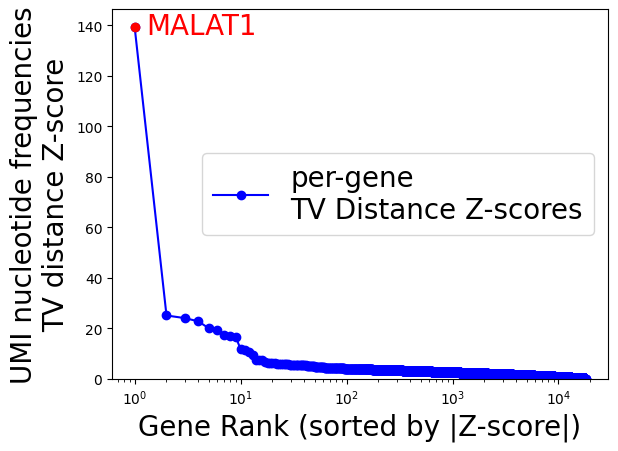

In [ ]:
############# Figure generation for paper: fig:malat_detection_zscore


num_to_plot = len(all_genes_per_bp_freqs_df)
abs_z_scores = np.sort(np.abs(all_genes_per_bp_freqs_df['TV_distance_from_uniform_z'].values))[::-1][:num_to_plot]
####### plot, highlight top 1 as red and label as MALAT1
plt.plot(1+np.arange(num_to_plot), abs_z_scores, marker='o', color='blue', label='per-gene\nTV Distance Z-scores')
plt.xscale('log')
plt.ylim(bottom = 0)
plt.ylabel('UMI nucleotide frequencies\nTV distance Z-score', fontsize=20)
plt.xlabel('Gene Rank (sorted by |Z-score|)', fontsize=20)
plt.legend(fontsize=20,loc='right')
###### label the top 1 as MALAT1
plt.text(1.3, abs_z_scores[0]-3, 'MALAT1', color='red', fontsize=20, ha='left')
plt.plot(1, abs_z_scores[0], marker='o', color='red')  # Highlight the point for MALAT1
plt.savefig(save_dir+'/detect_malat1_tv_distance_zscore.pdf', bbox_inches='tight')


In [ ]:
def var_y(n, K=4**5):
    """
    Compute the variance of the number of unique UMIs observed in a sample of size n.

    Parameters
    ----------
    n : int or array-like
        Number of sampled UMIs (sample size).
    K : int, optional
        Total number of possible UMIs (default is 4**5 = 1024).

    Returns
    -------
    float or np.ndarray
        The variance of the number of unique UMIs observed.

    Notes
    -----
    The formula used is:
        Var(Y) = K * (1 - 1/K)^n + K*(K-1)*(1 - 2/K)^n - K^2*(1 - 1/K)^{2n}
    where Y is the number of unique UMIs observed.
    """
    return K * (1 - 1 / K) ** n + K * (K - 1) * (1 - 2 / K) ** n - K ** 2 * (1 - 1 / K) ** (2 * n)


def var_y_nonunif_vectorized(n, umi_prob_arr):
    """
    Compute the variance of the number of unique UMIs observed for sample size(s) n.

    This version is optimized using NumPy vectorization to avoid slow Python loops
    over the UMI probabilities, making it significantly faster when K is large. It
    also correctly handles cases where n is an array of sample sizes.

    Parameters
    ----------
    n : int or np.ndarray
        Number of sampled UMIs (sample size). Can be a single integer or an
        array of integers.
    umi_prob_arr : np.ndarray
        1D array of UMI probabilities, which should sum to 1.

    Returns
    -------
    float or np.ndarray
        The variance of Y, matching the input type of n (scalar or array).
    """
    # Ensure n is an iterable array for the main loop
    is_scalar_input = np.isscalar(n)
    n_arr = np.array([n]) if is_scalar_input else np.asarray(n)

    p = np.asarray(umi_prob_arr)
    results = np.zeros(n_arr.shape)

    # --- Pre-calculate the KxK matrix of pairwise probability sums (p_j + p_k) ---
    # This uses broadcasting to avoid a O(K^2) Python loop and is the key optimization.
    p_outer_sum = p[:, np.newaxis] + p
    
    # --- Loop over each sample size n ---
    # This loop is efficient as the number of different n values is usually small.
    for i, current_n in enumerate(n_arr):
        # Calculate v_j = (1-p_j)^n, a term used multiple times
        one_minus_p_pow_n = (1 - p) ** current_n

        # --- Part 1: Sum of Variances: Σ Var(I_j) ---
        # This term is easily vectorized.
        var_term = np.sum(one_minus_p_pow_n - one_minus_p_pow_n**2)

        # --- Part 2: Sum of Covariances: Σ_{j≠k} Cov(I_j, I_k) ---
        # We calculate this as Component A - Component B.
        
        # Component A: Σ_{j≠k} (1 - p_j - p_k)^n
        # We raise the pre-calculated KxK matrix to the power of n.
        cov_A_matrix = (1 - p_outer_sum) ** current_n
        # We sum all elements and subtract the diagonal (where j=k).
        cov_term_A = np.sum(cov_A_matrix) - np.sum(np.diag(cov_A_matrix))

        # Component B: Σ_{j≠k} (1-p_j)^n * (1-p_k)^n
        # This is calculated efficiently using the identity:
        # (Σv_j)² = Σv_j² + Σ_{j≠k}v_j v_k
        sum_v = np.sum(one_minus_p_pow_n)
        sum_v_sq = np.sum(one_minus_p_pow_n**2)
        cov_term_B = sum_v**2 - sum_v_sq
        
        # Combine all parts for the total variance
        results[i] = var_term + cov_term_A - cov_term_B
        
    # Return a scalar if the input n was a scalar, otherwise return the array
    return results[0] if is_scalar_input else results

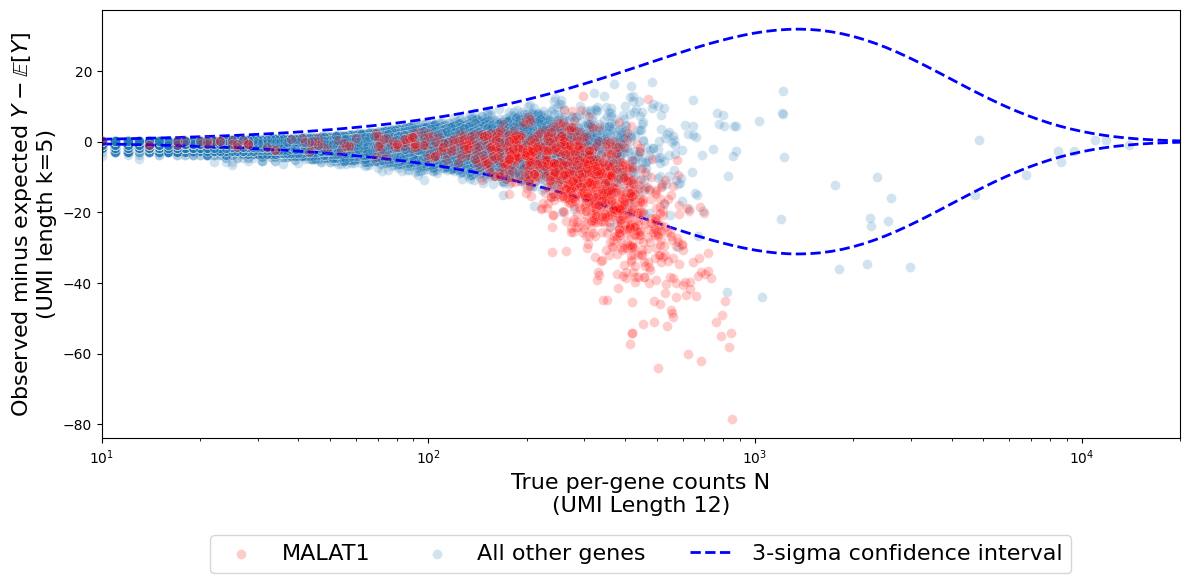

In [ ]:
############# Figure generation for paper: fig:len_5_nonunif_forward_model_MALAT1


min_ct_threshold = 10

plt.figure()
j=5
K= 4**j


len_12_cts_mat = adata_dict[12].X[:, adata_dict[12].var_names != 'MALAT1'].flatten()
len_5_cts_mat = adata_dict[5].X[:, adata_dict[5].var_names != 'MALAT1'].flatten()
idxs_to_keep = len_12_cts_mat >= min_ct_threshold
len_12_cts_reduced = len_12_cts_mat[idxs_to_keep]
len_5_cts_reduced = len_5_cts_mat[idxs_to_keep]

naive_pred = naive_pred_f(len_12_cts_reduced,j)

n_min = min_ct_threshold
n_max = 20000
n_range = np.logspace(np.log10(n_min), np.log10(n_max), 100, dtype=int)
naive_pred_nrange = compute_naive_unif_estimator(n_range, K)

umi_per_bp_prob_arr = np.array(list(base_frequencies.values()))
synthetic_umi_prob_arr = construct_synthetic_umi_arr_perbp(umi_per_bp_prob_arr, length=5)
non_unif_estimates_perbp = [compute_non_unif_estimator(synthetic_umi_prob_arr, n, K) for n in n_range]

non_unif_ests_len5 = np.array([compute_non_unif_estimator(synthetic_umi_prob_arr, n, K) for n in len_12_cts_reduced])


################# plot only the MALAT1 gene
plot_MALAT1 = True
if plot_MALAT1:
    len_12_cts_mat_MALAT1 = adata_dict[12].X[:, adata_dict[12].var_names == 'MALAT1'].flatten()
    len_5_cts_mat_MALAT1 = adata_dict[5].X[:, adata_dict[5].var_names == 'MALAT1'].flatten()
    idxs_to_keep_MALAT1 = len_12_cts_mat_MALAT1 >= min_ct_threshold
    len_12_cts_reduced_MALAT1 = len_12_cts_mat_MALAT1[idxs_to_keep_MALAT1]
    len_5_cts_reduced_MALAT1 = len_5_cts_mat_MALAT1[idxs_to_keep_MALAT1]

    naive_pred_MALAT1 = naive_pred_f(len_12_cts_reduced_MALAT1, j)
    nonunif_est_MALAT1 = np.array([compute_non_unif_estimator(synthetic_umi_prob_arr, n, K) for n in len_12_cts_reduced_MALAT1])
    plt.scatter(len_12_cts_reduced_MALAT1, len_5_cts_reduced_MALAT1 - nonunif_est_MALAT1, alpha=0.2, 
                edgecolors='w', s=50, linewidth=0.5, label='MALAT1', color='red', zorder=100)



plt.scatter(len_12_cts_reduced, len_5_cts_reduced - non_unif_ests_len5, alpha=0.2, 
            edgecolors='w', s=50, linewidth=0.5, label='All other genes')

sigma_conf = np.sqrt(var_y_nonunif_vectorized(n_range, synthetic_umi_prob_arr))
###### add dashed blue lines at +/- 3 sigma confidence intervals around opt_pred-naive_pred_nrange
plt.plot(n_range, 3*sigma_conf, linestyle='--', color='blue', linewidth=2, label='3-sigma confidence interval')
plt.plot(n_range, -3*sigma_conf, linestyle='--', color='blue', linewidth=2)


plt.xlabel('True per-gene counts N\n(UMI Length 12)', fontsize=16)
plt.ylabel(r'Observed minus expected $Y-\mathbb{E}[Y]$'+'\n(UMI length k=5)', fontsize=16)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=16)
plt.xscale('log')
plt.xlim([n_min, n_max])
plt.gcf().set_size_inches(12, 6)
plt.tight_layout()

plt.savefig(save_dir+'/len_5_nonunif_forward_model_MALAT1.pdf', bbox_inches='tight')
